In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import mesh
import geometry
import material
from stress_strain_analysis import stress_strain_analysis

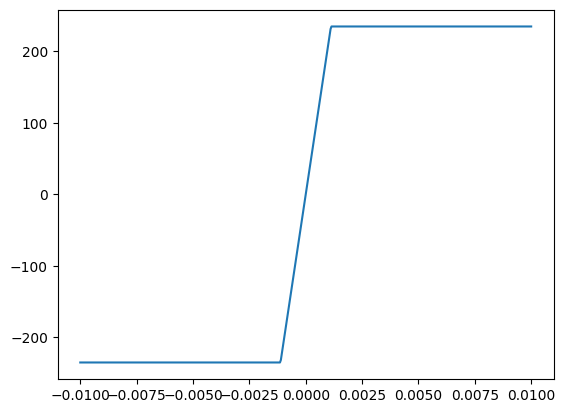

In [2]:
steel = material.Steel_S235()

strains = np.linspace(-0.01, 0.01, 500)
stresses = steel.get_stress_vectorized(strains)

plt.plot(strains, stresses)
plt.show()

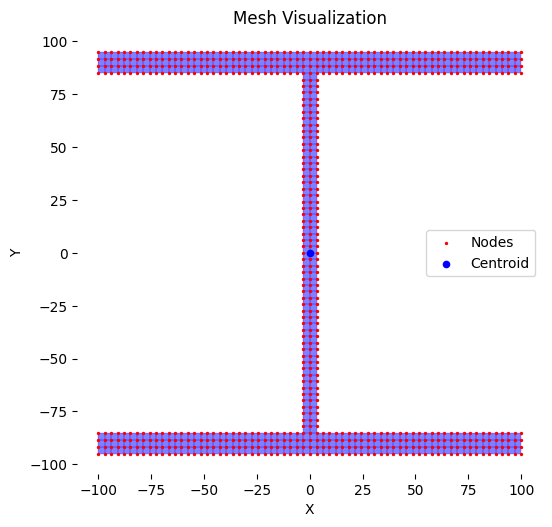

╒════════════════════╤═══════════════╕
│ Mesh Type          │ quadrilateral │
├────────────────────┼───────────────┤
│ Number of elements │ 508           │
├────────────────────┼───────────────┤
│ Number of nodes    │ 701           │
├────────────────────┼───────────────┤
│ Cross Section Area │ 5105.00       │
╘════════════════════╧═══════════════╛
╒═══════════════════╤═════════════╤═════════════╕
│                   │           X │           Y │
╞═══════════════════╪═════════════╪═════════════╡
│ Centroid          │       -0.00 │        0.00 │
├───────────────────┼─────────────┼─────────────┤
│ Moment of inertia │ 35094541.67 │ 13337223.85 │
╘═══════════════════╧═════════════╧═════════════╛


In [3]:
H    = geometry.H_beam(web_width     =   6.5,
                       web_height    = 170.0,
                       flange_width  = 200.0,
                       flange_height =  10.0)
Mesh = mesh.Mesh(H, "quadrilateral", 3)

Mesh.plot()
Mesh.print()

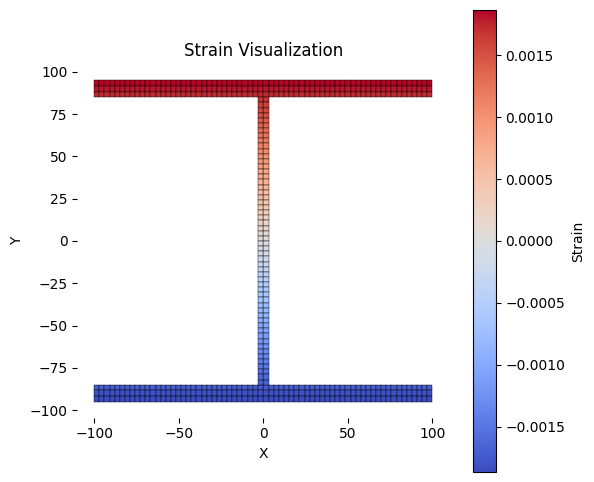

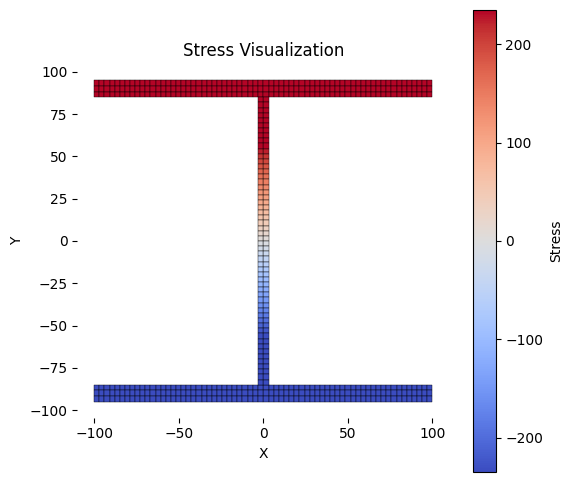

In [4]:
Analysis = stress_strain_analysis(Mesh)

Analysis.set_strain_and_curvature(0.00, 0.00002, 0.0)

Analysis.calculate_strains()
Analysis.plot_strains()

Analysis.calculate_stresses()
Analysis.plot_stresses()

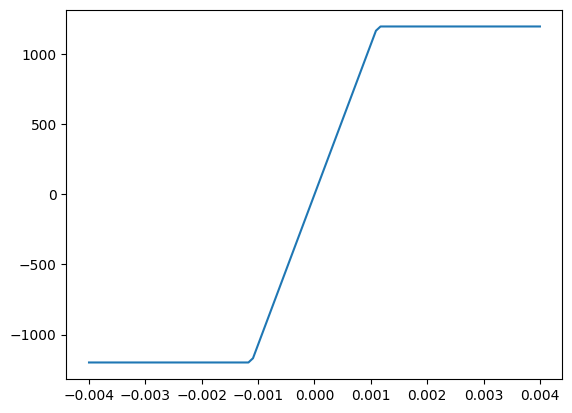

In [5]:
strains = np.linspace(-0.004, 0.004, 100)

Nx = []

for strain in strains:
    Analysis.set_strain_and_curvature(strain, 0, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx.append(Analysis.get_section_forces()[0])

plt.plot(strains, Nx)
plt.show()

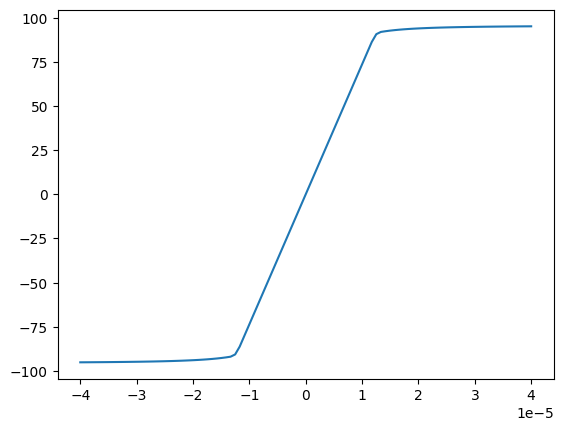

In [6]:
curvs = np.linspace(-0.00004, 0.00004, 100)

My = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])

plt.plot(curvs, My)
plt.show()

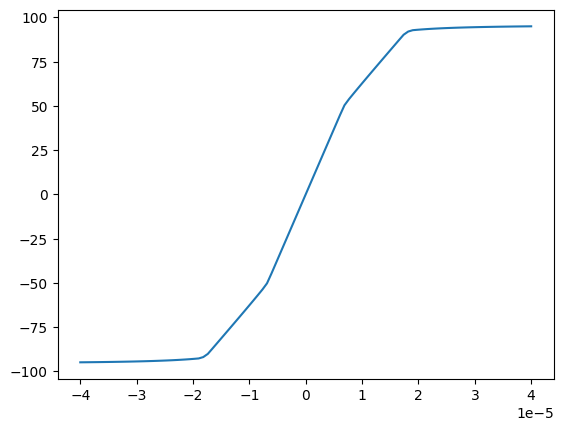

In [91]:
curvs = np.linspace(-0.00004, 0.00004, 100)

My = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0.0005, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])

plt.plot(curvs, My)
plt.show()

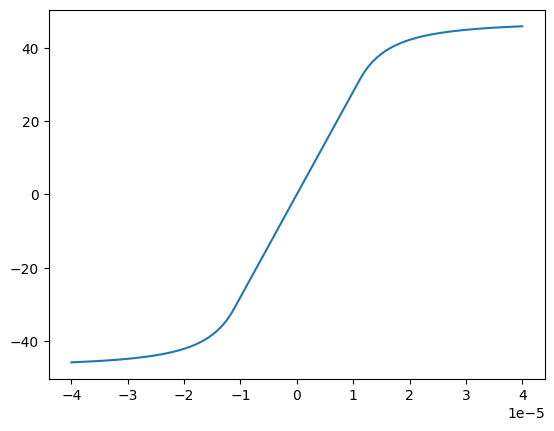

In [93]:
curvs = np.linspace(-0.00004, 0.00004, 100)

Mz = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0.0, 0, curv)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Mz.append(Analysis.get_section_forces()[2])

plt.plot(curvs, Mz)
plt.show()

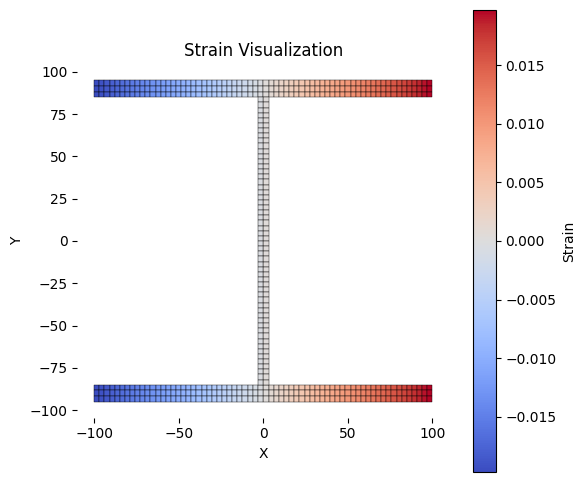

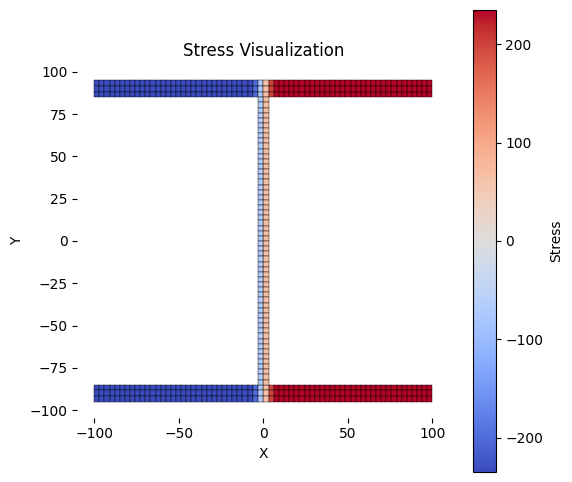

Nx =  6.290292731137015e-13 kN
My =  -5.698821041733027e-13 kNm
Mz =  47.06716550711652 kNm


In [90]:
Analysis.set_strain_and_curvature(0.0, 0.0, 0.0002)
Analysis.calculate_strains()
Analysis.calculate_stresses()
Analysis.plot_strains()
Analysis.plot_stresses()
print("Nx = ", Analysis.get_section_forces()[0], "kN")
print("My = ", Analysis.get_section_forces()[1], "kNm")
print("Mz = ", Analysis.get_section_forces()[2], "kNm")

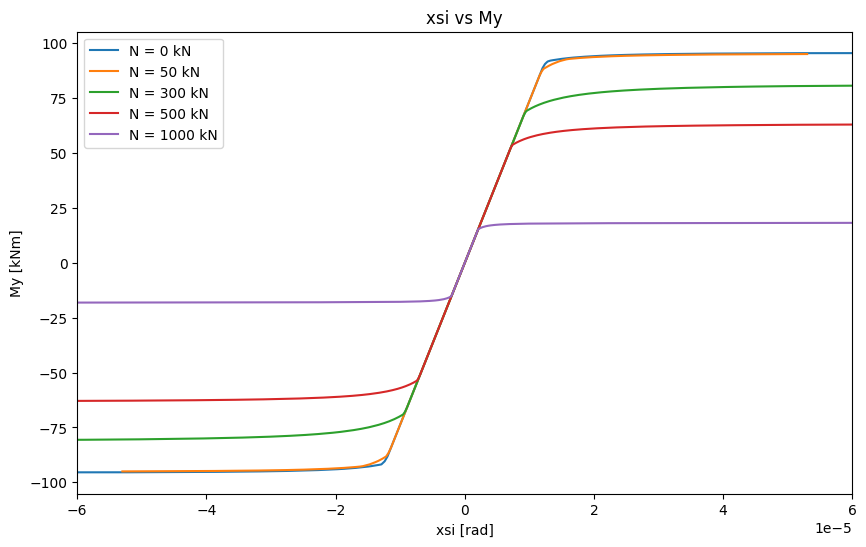

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(-100, 100, 1001)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
plt.figure(figsize=(10, 6))
for target_N in [0, 50, 300, 500, 1000]:
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(target_N, target_M, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	plt.plot(xsi, M_res,linestyle='-', label=f'N = {target_N} kN')

# Plotting the results
plt.title('xsi vs My')
plt.legend()
plt.xlim(-0.00006, 0.00006)
plt.xlabel('xsi [rad]')
plt.ylabel('My [kNm]')
plt.show()

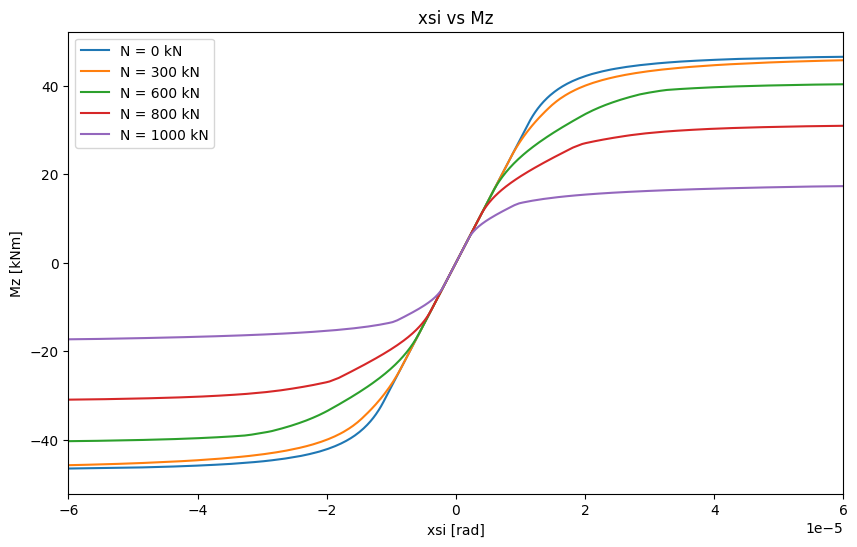

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Mz = np.linspace(-100, 100, 1001)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
plt.figure(figsize=(10, 6))
for target_N in [0, 300, 600, 800, 1000]:
	xsi = []
	M_res = []
	for i, M in enumerate(Mz):
		target_M = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(target_N, 0, target_M), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][2])  # Append the xsi value
			M_res.append(M)
	plt.plot(xsi, M_res,linestyle='-', label=f'N = {target_N} kN')

# Plotting the results
plt.title('xsi vs Mz')
plt.legend()
plt.xlim(-0.00006, 0.00006)
plt.xlabel('xsi [rad]')
plt.ylabel('Mz [kNm]')
plt.show()

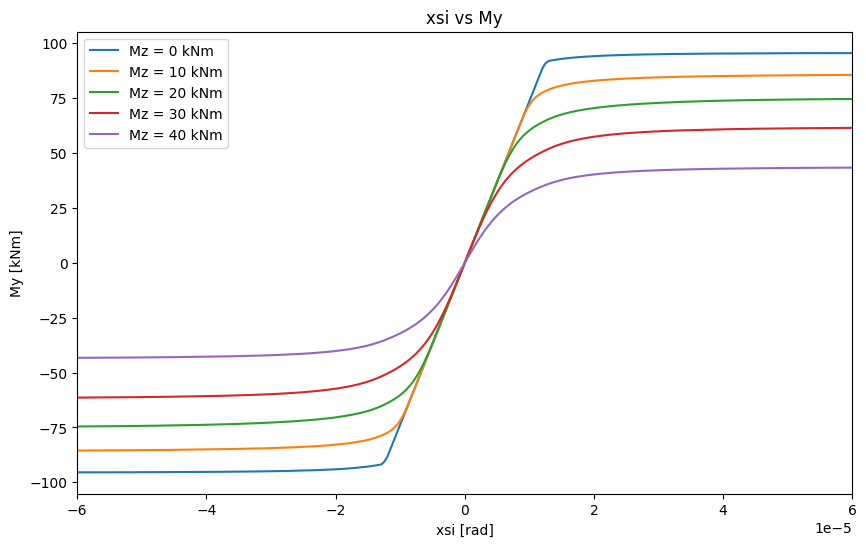

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(-100, 100, 1001)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
plt.figure(figsize=(10, 6))
for target_Mz in [0, 10, 20, 30, 40]:
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		target_My = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(0, target_My, target_Mz), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	plt.plot(xsi, M_res,linestyle='-', label=f'Mz = {target_Mz} kNm')

# Plotting the results
plt.title('xsi vs My')
plt.legend()
plt.xlim(-0.00006, 0.00006)
plt.xlabel('xsi [rad]')
plt.ylabel('My [kNm]')
plt.show()

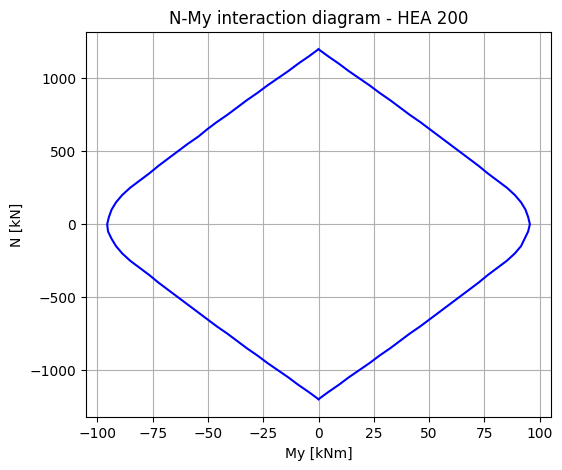

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-1150, 1150, 47)
My = np.linspace(-100, 100, 501)
M_min = [0]
M_max = [0]
Mz = 0

# Find N_min and N_max
N_large = np.linspace(0, 2000, 2001)
N_small = np.linspace(0,-2000, 2001)
N_min = 0
N_max = 0

for i, N_target in enumerate(N_large):
	initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_max = N_target

for i, N_target in enumerate(N_small):
	initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_min = N_target

N_solutions = [N_min]

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]

for i, N_target in enumerate(N):
	M_res = []
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, target_M, Mz), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			M_res.append(M)
	if len(M_res) > 0:
		# Append the minimum and maximum M values for the current N
		# Check if M_res is not empty before appending
		M_min.append(min(M_res))
		M_max.append(max(M_res))
		N_solutions.append(N_target)

M_min.append(0)
M_max.append(0)
N_solutions.append(N_max)

# Plotting the results
plt.figure(figsize=(6, 5))
plt.plot(M_min, N_solutions,linestyle='-', color='b')
plt.plot(M_max, N_solutions,linestyle='-', color='b')
plt.grid()
plt.xlabel('My [kNm]')
plt.ylabel('N [kN]')
plt.title('N-My interaction diagram - HEA 200')
plt.show()


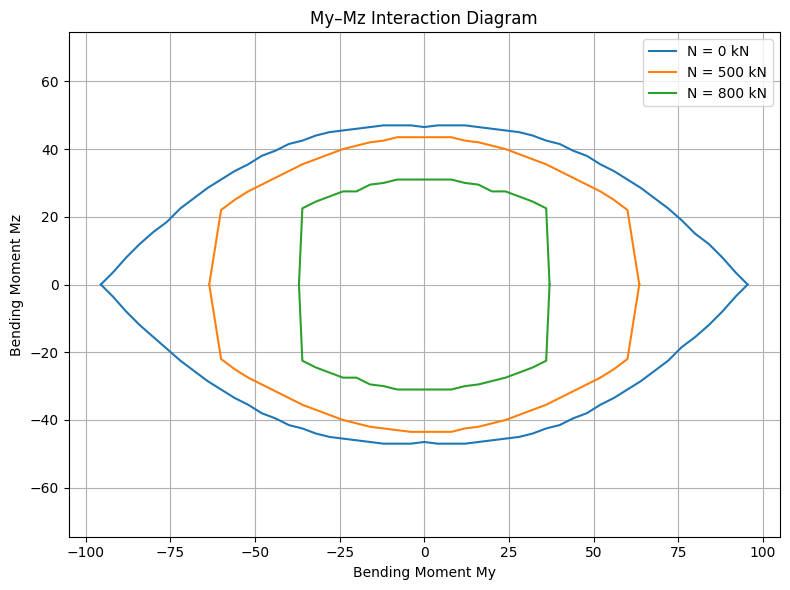

In [120]:
plt.figure(figsize=(8, 6))
c = ['C0', 'C1', 'C2']

for i, N_target in enumerate([0, 500, 800]):
	# --- Parameters ---
	My_range = np.linspace(-100, 100, 51)
	Mz_range = np.linspace(-100, 100, 401)

	# --- Initialize result containers ---
	Mz_neg = [0]
	Mz_pos = [0]

	# Find My_min and My_max
	My = np.linspace(0, 100, 201)

	for My_target in My:
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			My_max = My_target

	My_sol = [-My_max]

	# --- Main sweep over My and Mz grid ---
	for My in My_range:
		Mz_success = []
		for Mz in Mz_range:
			initial_guess = [0.0, 0.0, 0.0]
			result = fsolve(system_of_equations, initial_guess, args=(N_target, My, Mz), full_output=1)
			if result[2] == 1:
				Mz_success.append(Mz)
		if len(Mz_success) > 0:
			My_sol.append(My)
			Mz_neg.append(min(Mz_success))
			Mz_pos.append(max(Mz_success))
	
	My_sol.append(My_max)
	Mz_neg.append(0)
	Mz_pos.append(0)

	plt.plot(My_sol, Mz_neg, color=c[i])
	plt.plot(My_sol, Mz_pos, color=c[i], label=f"N = {N_target} kN")


plt.xlabel("Bending Moment My")
plt.ylabel("Bending Moment Mz")
plt.title("My–Mz Interaction Diagram")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
result = fsolve(system_of_equations, initial_guess, args=(400, 10, 11), full_output=1)
print(result[2])

1


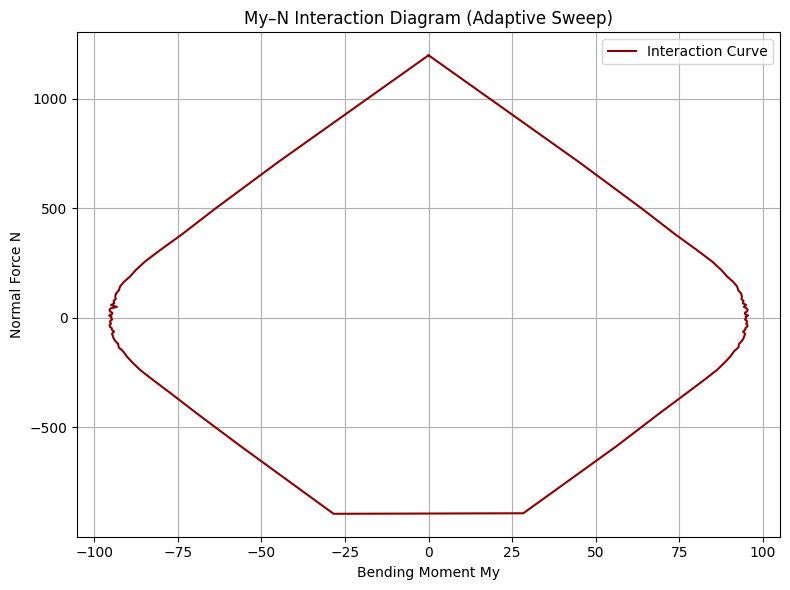

In [34]:
def system_of_equations(V, N_target, My_target, Mz_target):
    Analysis.set_strain_and_curvature(V[0], V[1], V[2])
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx, My, Mz = Analysis.get_section_forces()
    return [Nx - N_target, My - My_target, Mz - Mz_target]

# --- Check if a solution exists for given R and angle θ ---
def system_has_solution(R, theta):
    N_target = R * np.cos(theta)
    My_target = R * np.sin(theta)
    initial_guess = [0.0, 0.0, 0.0]
    result = fsolve(system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
    return result[2] == 1  # Convergence success

angles = np.linspace(0, 2 * np.pi, 100)
N_values = []
M_values = []

R_range = np.linspace(0, 1200, 1000)  # Adjust max range as needed

for theta in angles:
    R_found = None
    for R in R_range:
        if system_has_solution(R, theta):
            R_found = R
        else:
            continue
    if R_found is not None:
        N_values.append(R_found * np.cos(theta))
        M_values.append(R_found * np.sin(theta))

plt.figure(figsize=(8, 6))
plt.plot(M_values, N_values, label="Interaction Curve", color="darkred")
plt.xlabel("Bending Moment My")
plt.ylabel("Normal Force N")
plt.title("My–N Interaction Diagram (Adaptive Sweep)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()